In [19]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, size=5000, dim=40, random_offset=0):
        super(MyDataset, self).__init__()
        self.size = size
        self.dim = dim
        self.random_offset = random_offset

    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError("{} index out of range".format(self.__class__.__name__))

        rng_state = torch.get_rng_state()
        torch.manual_seed(index + self.random_offset)

        while True:
            img = torch.zeros(self.dim, self.dim) #40*40
            dx = torch.randint(-10,10,(1,),dtype=torch.float) #1,
            dy = torch.randint(-10,10,(1,),dtype=torch.float) #1,
            c = torch.randint(-20,20,(1,), dtype=torch.float) #1,

            params = torch.cat((dy/dx, c)) #1*2
            xy = torch.randint(0,img.shape[1], (20, 2), dtype=torch.float) #20*2,range[0,40]
            xy[:,1] = xy[:,0] * params[0] + params[1] #20*2, column2 = column1 * dydx + c

            xy.round_() #Nearest Integers
            xy = xy[ xy[:,1] > 0 ] #Shuffle to all column2 > 0
            xy = xy[ xy[:,1] < self.dim ] #Shuffle to all column2 < 40
            xy = xy[ xy[:,0] < self.dim ] #Shuffle to all column1 < 40

            for i in range(xy.shape[0]):
                x, y = xy[i][0], self.dim - xy[i][1] # x=element_x, y=40-element_y
                img[int(y), int(x)]=1 # img[randomlocation[y,x]]=1,img[other]=0
            if img.sum() > 2: # generator have meaning
                break
        
        torch.set_rng_state(rng_state)
        return img.unsqueeze(0), params

    def __len__(self):
        return self.size

train_data = MyDataset()
val_data = MyDataset(size=500, random_offset=33333)
test_data = MyDataset(size=500, random_offset=99999)

In [3]:
from torch.utils.data import DataLoader
# # convert each image to tensor format
# transform = transforms.Compose([
#     transforms.ToTensor()  # convert to tensor
# ])

# # load data
# trainset = MNIST(".", train=True, download=True, transform=transform)
# testset = MNIST(".", train=False, download=True, transform=transform)

# create data loaders
trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
validloader = DataLoader(val_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [117]:
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torchbearer import Trial

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 48, 
                               kernel_size = (3, 3), stride=1,padding=1)
        self.fc1 = nn.Linear(48 * 40**2, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        x = x.to(device)
        out = self.conv1(x)
        out = F.relu(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
# build the model
model = SimpleCNN()

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model, optimiser, loss_function, metrics=['loss'])
trial.with_generators(trainloader, val_generator=validloader,
                      test_generator=testloader).to(device)
trial.run(epochs=100)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)

0/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

0/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

1/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

1/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

2/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

2/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

3/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

3/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

4/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

4/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

5/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

5/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

6/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

6/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

7/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

7/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

8/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

8/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

9/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

9/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

10/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

10/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

11/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

11/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

12/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

12/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

13/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

13/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

14/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

14/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

15/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

15/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

16/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

16/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

17/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

17/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

18/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

18/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

19/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

19/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

20/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

20/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

21/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

21/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

22/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

22/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

23/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

23/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

24/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

24/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

25/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

25/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

26/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

26/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

27/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

27/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

28/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

28/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

29/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

29/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

30/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

30/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

31/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

31/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

32/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

32/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

33/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

33/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

34/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

34/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

35/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

35/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

36/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

36/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

37/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

37/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

38/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

38/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

39/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

39/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

40/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

40/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

41/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

41/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

42/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

42/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

43/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

43/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

44/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

44/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

45/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

45/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

46/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

46/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

47/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

47/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

48/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

48/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

49/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

49/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

50/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

50/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

51/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

51/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

52/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

52/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

53/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

53/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

54/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

54/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

55/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

55/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

56/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

56/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

57/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

57/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

58/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

58/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

59/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

59/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

60/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

60/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

61/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

61/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

62/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

62/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

63/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

63/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

64/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

64/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

65/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

65/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

66/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

66/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

67/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

67/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

68/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

68/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

69/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

69/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

70/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

70/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

71/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

71/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

72/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

72/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

73/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

73/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

74/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

74/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

75/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

75/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

76/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

76/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

77/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

77/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

78/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

78/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

79/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

79/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

80/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

80/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

81/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

81/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

82/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

82/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

83/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

83/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

84/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

84/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

85/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

85/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

86/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

86/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

87/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

87/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

88/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

88/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

89/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

89/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

90/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

90/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

91/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

91/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

92/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

92/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

93/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

93/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

94/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

94/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

95/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

95/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

96/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

96/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

97/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

97/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

98/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

98/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

99/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

99/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

0/1(e):   0%|          | 0/4 [00:00<?, ?it/s]

{'test_loss': 10.545927047729492}


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor(7.)
tensor([ 1.3333, 13.0000])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([ 1.4013, 12.0582], device='cuda:0', grad_fn=<SelectBackward0>)


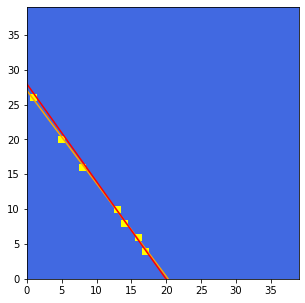

In [154]:
im,params = test_data[80]
print(im)
print(im.sum())
print(params)
print(im.unsqueeze(0))
est_params = model(im.unsqueeze(0))[0]
print(est_params)
x0, x1 = 0, 40
y0, y1 = 0, 40
# m,c = torch.tensor(params, device='cpu')
m,c = params.clone().detach().to('cpu')
m,c = -m, (-c+40)
m_est, c_est = est_params.clone().detach().to('cpu')
m_est, c_est = -m_est, (-c_est+40)
px0, px1 = x0 - 5, x1 + 5
x = torch.linspace(px0, px1, px1 - px0).detach()
y = m * x + c
y_est = m_est * x + c_est
plt.subplots(figsize = (5, 5))
plt.imshow(im.squeeze(),cmap=matplotlib.colors.ListedColormap(['royalblue', 'yellow']))
plt.plot(x, y, c = 'orange')
plt.plot(x, y_est, c = 'red')
plt.xlim(0,39)
plt.ylim(0,39)
plt.savefig("SimpleCNN80.png")

In [125]:
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchbearer import Trial

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

class CNNPooling(nn.Module):
    def __init__(self):
        super(CNNPooling, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 48, kernel_size = (3, 3), stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size = (3, 3), stride=1,padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(48, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        x = x.to(device)
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = F.adaptive_max_pool2d(out,output_size=(1,1))
        out = self.flatten(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
# build the model
model2 = CNNPooling()

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model2.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model2, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, val_generator=validloader,test_generator=testloader)
trial.run(epochs=100)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)

0/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

0/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

1/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

1/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

2/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

2/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

3/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

3/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

4/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

4/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

5/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

5/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

6/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

6/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

7/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

7/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

8/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

8/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

9/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

9/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

10/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

10/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

11/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

11/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

12/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

12/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

13/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

13/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

14/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

14/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

15/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

15/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

16/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

16/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

17/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

17/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

18/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

18/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

19/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

19/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

20/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

20/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

21/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

21/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

22/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

22/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

23/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

23/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

24/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

24/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

25/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

25/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

26/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

26/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

27/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

27/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

28/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

28/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

29/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

29/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

30/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

30/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

31/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

31/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

32/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

32/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

33/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

33/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

34/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

34/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

35/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

35/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

36/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

36/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

37/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

37/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

38/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

38/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

39/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

39/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

40/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

40/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

41/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

41/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

42/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

42/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

43/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

43/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

44/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

44/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

45/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

45/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

46/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

46/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

47/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

47/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

48/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

48/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

49/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

49/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

50/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

50/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

51/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

51/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

52/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

52/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

53/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

53/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

54/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

54/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

55/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

55/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

56/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

56/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

57/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

57/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

58/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

58/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

59/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

59/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

60/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

60/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

61/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

61/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

62/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

62/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

63/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

63/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

64/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

64/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

65/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

65/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

66/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

66/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

67/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

67/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

68/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

68/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

69/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

69/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

70/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

70/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

71/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

71/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

72/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

72/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

73/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

73/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

74/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

74/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

75/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

75/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

76/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

76/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

77/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

77/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

78/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

78/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

79/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

79/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

80/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

80/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

81/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

81/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

82/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

82/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

83/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

83/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

84/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

84/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

85/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

85/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

86/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

86/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

87/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

87/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

88/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

88/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

89/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

89/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

90/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

90/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

91/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

91/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

92/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

92/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

93/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

93/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

94/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

94/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

95/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

95/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

96/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

96/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

97/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

97/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

98/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

98/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

99/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

99/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

0/1(e):   0%|          | 0/4 [00:00<?, ?it/s]

{'test_loss': 16.564319610595703, 'test_mse': 16.64059829711914}


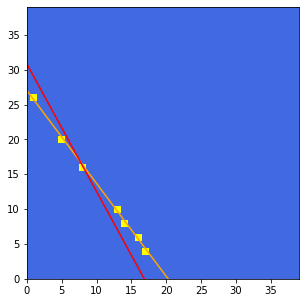

In [162]:
im,params = test_data[80]
est_params = model2(im.unsqueeze(0))[0]
x0, x1 = 0, 40
y0, y1 = 0, 40
# m,c = torch.tensor(params, device='cpu')
m,c = params.clone().detach().to('cpu')
m,c = -m, (-c+40)
m_est, c_est = est_params.clone().detach().to('cpu')
m_est, c_est = -m_est, (-c_est+40)
px0, px1 = x0 - 5, x1 + 5
x = torch.linspace(px0, px1, px1 - px0).detach()
y = m * x + c
y_est = m_est * x + c_est
plt.subplots(figsize = (5, 5))
plt.imshow(im.squeeze(),cmap=matplotlib.colors.ListedColormap(['royalblue', 'yellow']))
plt.plot(x, y, c = 'orange')
plt.plot(x, y_est, c = 'red')
plt.xlim(0,39)
plt.ylim(0,39)
plt.savefig("CNNPooling80.png")

In [133]:
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchbearer import Trial

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 48, kernel_size = (3, 3), stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size = (3, 3), stride=1,padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(48, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        x = x.to(device)
        idxx = torch.repeat_interleave(
            torch.arange(-20,20,dtype=torch.float).unsqueeze(0)/40.0,
            repeats = 40,dim = 0).to(x.device) # random 1*40 in[-0.5,0.5] #repeats 40 to 40*40
        idxy = idxx.clone().t()                #transpose
        idx = torch.stack([idxx,idxy]).unsqueeze(0) #integration to [1,2,40,40]
        idx = torch.repeat_interleave(
            idx,repeats=x.shape[0],dim=0)     #repeats 40 to [40,2,40,40]
        x = torch.cat([x,idx],dim=1)          #[40, 1, 40, 40] cat [40,2,40,40] to [40,3,40,40]
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = F.adaptive_max_pool2d(out,output_size=(1,1))
        out = self.flatten(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
# build the model
model3 = CNN3()

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model3.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model3, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, val_generator=validloader,test_generator=testloader)
trial.run(epochs=100)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)

0/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

0/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

1/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

1/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

2/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

2/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

3/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

3/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

4/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

4/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

5/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

5/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

6/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

6/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

7/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

7/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

8/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

8/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

9/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

9/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

10/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

10/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

11/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

11/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

12/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

12/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

13/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

13/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

14/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

14/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

15/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

15/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

16/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

16/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

17/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

17/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

18/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

18/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

19/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

19/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

20/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

20/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

21/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

21/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

22/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

22/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

23/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

23/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

24/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

24/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

25/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

25/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

26/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

26/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

27/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

27/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

28/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

28/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

29/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

29/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

30/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

30/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

31/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

31/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

32/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

32/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

33/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

33/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

34/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

34/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

35/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

35/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

36/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

36/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

37/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

37/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

38/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

38/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

39/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

39/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

40/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

40/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

41/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

41/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

42/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

42/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

43/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

43/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

44/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

44/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

45/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

45/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

46/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

46/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

47/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

47/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

48/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

48/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

49/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

49/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

50/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

50/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

51/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

51/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

52/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

52/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

53/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

53/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

54/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

54/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

55/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

55/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

56/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

56/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

57/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

57/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

58/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

58/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

59/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

59/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

60/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

60/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

61/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

61/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

62/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

62/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

63/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

63/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

64/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

64/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

65/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

65/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

66/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

66/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

67/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

67/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

68/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

68/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

69/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

69/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

70/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

70/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

71/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

71/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

72/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

72/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

73/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

73/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

74/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

74/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

75/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

75/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

76/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

76/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

77/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

77/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

78/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

78/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

79/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

79/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

80/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

80/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

81/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

81/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

82/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

82/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

83/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

83/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

84/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

84/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

85/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

85/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

86/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

86/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

87/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

87/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

88/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

88/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

89/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

89/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

90/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

90/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

91/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

91/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

92/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

92/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

93/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

93/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

94/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

94/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

95/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

95/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

96/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

96/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

97/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

97/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

98/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

98/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

99/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

99/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

0/1(e):   0%|          | 0/4 [00:00<?, ?it/s]

{'test_loss': 1.307950496673584, 'test_mse': 1.307632327079773}


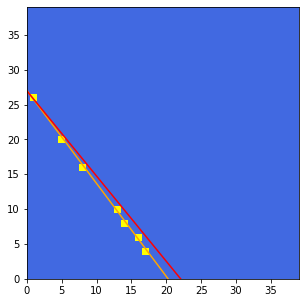

In [170]:
im,params = test_data[80]
est_params = model3(im.unsqueeze(0))[0]
x0, x1 = 0, 40
y0, y1 = 0, 40
# m,c = torch.tensor(params, device='cpu')
m,c = params.clone().detach().to('cpu')
m,c = -m, (-c+40)
m_est, c_est = est_params.clone().detach().to('cpu')
m_est, c_est = -m_est, (-c_est+40)
px0, px1 = x0 - 5, x1 + 5
x = torch.linspace(px0, px1, px1 - px0).detach()
y = m * x + c
y_est = m_est * x + c_est
plt.subplots(figsize = (5, 5))
plt.imshow(im.squeeze(),cmap=matplotlib.colors.ListedColormap(['royalblue', 'yellow']))
plt.plot(x, y, c = 'orange')
plt.plot(x, y_est, c = 'red')
plt.xlim(0,39)
plt.ylim(0,39)
plt.savefig("CNN80.png")

In [37]:
import torch
img = torch.zeros(40,40)
dx = torch.randint(-10,10,(1,),dtype=torch.float)
dy = torch.randint(-10,10,(1,),dtype=torch.float)
c = torch.randint(-20,20,(1,), dtype=torch.float)
print(img,dx,dy,c)
params = torch.cat((dy/dx, c))
xy = torch.randint(0,img.shape[1], (20, 2), dtype=torch.float)
print(params)
print(xy)
xy[:,1] = xy[:,0] * params[0] + params[1]
print(xy)
xy.round_()
print(xy)
xy = xy[ xy[:,1] > 0 ]
print(xy)
xy = xy[ xy[:,1] < 40 ]
print(xy)
xy = xy[ xy[:,0] < 40 ]
print(xy)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([3.]) tensor([6.]) tensor([-19.])
tensor([  2., -19.])
tensor([[16., 33.],
        [10.,  7.],
        [15., 10.],
        [18.,  2.],
        [31., 39.],
        [34., 33.],
        [ 7., 25.],
        [39.,  8.],
        [31., 36.],
        [31., 21.],
        [35., 13.],
        [17., 26.],
        [ 4.,  4.],
        [36., 12.],
        [28., 14.],
        [34., 25.],
        [28., 38.],
        [36., 24.],
        [ 0., 14.],
        [29., 23.]])
tensor([[ 16.,  13.],
        [ 10.,   1.],
        [ 15.,  11.],
        [ 18.,  17.],
        [ 31.,  43.],
        [ 34.,  49.],
        [  7.,  -5.],
        [ 39.,  59.],
        [ 31.,  43.],
        [ 31.,  43.],
        [ 35.,  51.],
        [ 17.,  15.],
        [  4., -11.

In [39]:
print(xy.shape[0])
for i in range(xy.shape[0]):
    x, y = xy[i][0], 40 - xy[i][1]
    print(x,y)
    img[int(y), int(x)]=1
print(img)
print(img.size())

8
tensor(16.) tensor(27.)
tensor(10.) tensor(39.)
tensor(15.) tensor(29.)
tensor(18.) tensor(23.)
tensor(17.) tensor(25.)
tensor(28.) tensor(3.)
tensor(28.) tensor(3.)
tensor(29.) tensor(1.)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([40, 40])


In [44]:
input = torch.arange(-20,20,dtype=torch.float).unsqueeze(0)/40.0
print(input)
print(input.size())
idxx = torch.repeat_interleave( input,repeats = 40,dim = 0)
print(idxx)
print(idxx.size())
idxy = idxx.clone().t()
print(idxy)
print(idxy.size())
idx = torch.stack([idxx,idxy]).unsqueeze(0)
print(idx)
print(idx.size())
idx = torch.repeat_interleave(idx,repeats=img.shape[0],dim=0)
# print(idx)
print(idx.size())
img = torch.randn(40,1,40,40)
print(img.size())
img = torch.cat([img,idx],dim=1)
print(img.size())

tensor([[-0.5000, -0.4750, -0.4500, -0.4250, -0.4000, -0.3750, -0.3500, -0.3250,
         -0.3000, -0.2750, -0.2500, -0.2250, -0.2000, -0.1750, -0.1500, -0.1250,
         -0.1000, -0.0750, -0.0500, -0.0250,  0.0000,  0.0250,  0.0500,  0.0750,
          0.1000,  0.1250,  0.1500,  0.1750,  0.2000,  0.2250,  0.2500,  0.2750,
          0.3000,  0.3250,  0.3500,  0.3750,  0.4000,  0.4250,  0.4500,  0.4750]])
torch.Size([1, 40])
tensor([[-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        ...,
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750]])
torch.Size([40, 40])
tensor([[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        [-0.4750, -0.4750, -0.4750,  ..., -0.475